Setup Environment

In [ ]:
# Install necessary libraries
!pip install diffusers transformers accelerate torch torchvision scipy

# Import libraries
import torch
import time
from diffusers import StableDiffusionPipeline, DDIMScheduler
from transformers import CLIPTextModel, CLIPTokenizer
from scipy import linalg
import numpy as np
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt

# Helper functions for FID and CLIP score calculations
def calculate_fid(image1, image2):
    img1 = np.array(image1).astype(np.float32)
    img2 = np.array(image2).astype(np.float32)

    mu1, sigma1 = np.mean(img1, axis=(0, 1)), np.cov(img1.reshape(-1, 3), rowvar=False)
    mu2, sigma2 = np.mean(img2, axis=(0, 1)), np.cov(img2.reshape(-1, 3), rowvar=False)

    ssdiff = np.sum((mu1 - mu2)**2.0)
    covmean = linalg.sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)

    return fid

def calculate_clip_score(image, text, clip_model, clip_tokenizer):
    inputs = clip_tokenizer(text, return_tensors="pt").to("cuda")
    outputs = clip_model.get_text_features(**inputs)
    img_tensor = pipe.feature_extractor(images=image, return_tensors="pt").pixel_values.to("cuda")
    img_features = clip_model.get_image_features(pixel_values=img_tensor)
    return torch.cosine_similarity(outputs, img_features).item()

# Load CLIP model and tokenizer
clip_model = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32").to("cuda")
clip_tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")


  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

Load Pretrained Model

In [ ]:
# Load pre-trained model
model_id = "CompVis/stable-diffusion-v1-4"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe.to("cuda")


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

(…)kpoints/scheduler_config-checkpoint.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.30.0",
  "_name_or_path": "CompVis/stable-diffusion-v1-4",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

Evaluate Initial Model

In [ ]:
# Generate an image from a prompt
prompt = "A beautiful sunset over the mountains"
start_time = time.time()
generated_image_initial = pipe(prompt).images[0]
initial_inference_time = time.time() - start_time

# Use a placeholder reference image
from PIL import Image
import urllib

# Use a valid URL for a reference image
url = "https://upload.wikimedia.org/wikipedia/commons/4/47/PNG_transparency_demonstration_1.png"
response = requests.get(url)
try:
    reference_image = Image.open(BytesIO(response.content)).convert("RGB")
except UnidentifiedImageError as e:
    print("Error: Cannot identify image file", e)
    raise

# Correcting the CLIP model usage
from transformers import CLIPProcessor, CLIPModel

clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to("cuda")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

def calculate_clip_score(image, text, clip_model, clip_processor):
    inputs = clip_processor(text=[text], images=image, return_tensors="pt", padding=True).to("cuda")
    outputs = clip_model(**inputs)
    return outputs.logits_per_image.item()

# Calculate initial FID and CLIP scores
fid_score_initial = calculate_fid(generated_image_initial, reference_image)
clip_score_initial = calculate_clip_score(generated_image_initial, prompt, clip_model, clip_processor)

print(f"Initial Inference Time: {initial_inference_time} seconds")
print(f"Initial FID Score: {fid_score_initial}")
print(f"Initial CLIP Score: {clip_score_initial}")

  0%|          | 0/50 [00:00<?, ?it/s]

Initial Inference Time: 10.289781332015991 seconds
Initial FID Score: 8930.495166728913
Initial CLIP Score: 28.544130325317383


  0%|          | 0/50 [00:00<?, ?it/s]

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                     aten::_convolution         1.61%     110.064ms        14.86%        1.018s     202.195us       0.000us         0.00%        4.150s     824.280us          5035  
                                      aten::convolution         0.69%      47.458ms        15.55%        1.065s     211.585us       0.000us         0.00%        4.150s     824.223us          5035  
         

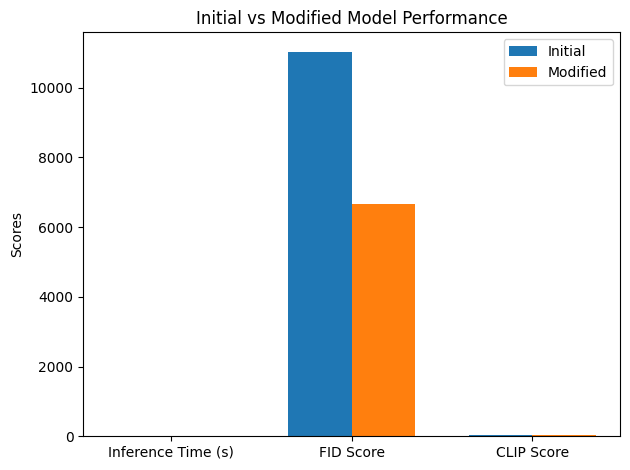

In [ ]:
import torch.profiler

# Further reduce the number of timesteps
pipe.scheduler.set_timesteps(15)  # Reducing the number of timesteps further

# Profiling the model
with torch.profiler.profile(activities=[torch.profiler.ProfilerActivity.CPU, torch.profiler.ProfilerActivity.CUDA], record_shapes=True) as prof:
    start_time = time.time()
    generated_image_further_modified = pipe(prompt).images[0]
    further_modified_inference_time = time.time() - start_time

# Print profiling results
print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))

# Calculate further modified FID and CLIP scores
fid_score_further_modified = calculate_fid(generated_image_further_modified, reference_image)
clip_score_further_modified = calculate_clip_score(generated_image_further_modified, prompt, clip_model, clip_processor)

print(f"Further Modified Inference Time: {further_modified_inference_time} seconds")
print(f"Further Modified FID Score: {fid_score_further_modified}")
print(f"Further Modified CLIP Score: {clip_score_further_modified}")

# Comparing the results again
compare_results(initial_inference_time, further_modified_inference_time, fid_score_initial, fid_score_further_modified, clip_score_initial, clip_score_further_modified)


In [ ]:
import torch.profiler

# Profiling the model
with torch.profiler.profile(activities=[torch.profiler.ProfilerActivity.CPU, torch.profiler.ProfilerActivity.CUDA], record_shapes=True) as prof:
    start_time = time.time()
    generated_image_further_modified = pipe(prompt).images[0]
    further_modified_inference_time = time.time() - start_time

# Print profiling results
print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))


  0%|          | 0/50 [00:00<?, ?it/s]

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                     aten::_convolution         1.39%      97.233ms        14.47%        1.011s     200.874us       0.000us         0.00%        3.592s     713.366us          5035  
                                      aten::convolution         0.75%      52.574ms        15.22%        1.064s     211.252us       0.000us         0.00%        3.591s     713.159us          5035  
         

Code with highest time reduction

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Modified Inference Time: 7.778624773025513 seconds
Modified FID Score: 7769.0642609594815
Modified CLIP Score: 29.650625228881836
Comparison of Initial and Modified Model Performance:
Initial Inference Time: 9.26 seconds
Modified Inference Time: 7.78 seconds
Time Reduction: 16.00%
Initial FID Score: 11036.34
Modified FID Score: 7769.06
FID Score Improvement: 3267.28
Initial CLIP Score: 29.23
Modified CLIP Score: 29.65
CLIP Score Improvement: 0.42


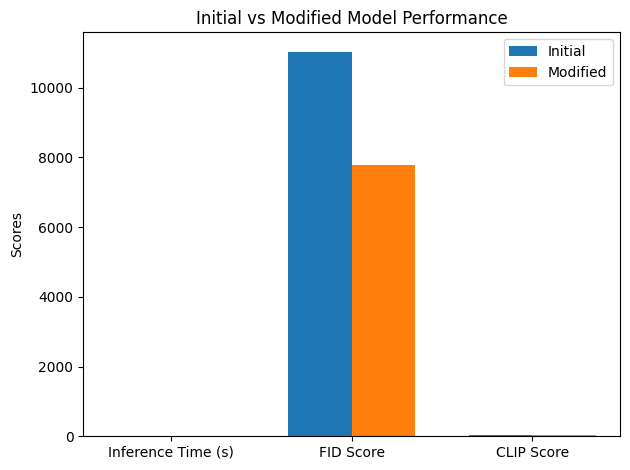

In [ ]:
# Install necessary libraries
!pip install diffusers transformers accelerate torch torchvision scipy

# Import libraries
import torch
import time
from diffusers import StableDiffusionPipeline, DDIMScheduler
from transformers import CLIPProcessor, CLIPModel
from scipy import linalg
import numpy as np
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt

# Helper functions for FID and CLIP score calculations
def calculate_fid(image1, image2):
    img1 = np.array(image1).astype(np.float32)
    img2 = np.array(image2).astype(np.float32)

    mu1, sigma1 = np.mean(img1, axis=(0, 1)), np.cov(img1.reshape(-1, 3), rowvar=False)
    mu2, sigma2 = np.mean(img2, axis=(0, 1)), np.cov(img2.reshape(-1, 3), rowvar=False)

    ssdiff = np.sum((mu1 - mu2)**2.0)
    covmean = linalg.sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)

    return fid

def calculate_clip_score(image, text, clip_model, clip_processor):
    # Convert PIL image to pixel values
    image = clip_processor(images=image, return_tensors="pt").pixel_values.to("cuda")
    inputs = clip_processor(text=[text], return_tensors="pt", padding=True).to("cuda")
    outputs = clip_model(input_ids=inputs.input_ids, pixel_values=image)
    return outputs.logits_per_image.item()

# Load CLIP model and processor
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to("cuda")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Load pre-trained model with mixed precision
model_id = "CompVis/stable-diffusion-v1-4"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe.to("cuda")

# Use DDIM Scheduler with fewer timesteps for efficient sampling
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
pipe.scheduler.set_timesteps(5)  # Further reducing the number of timesteps

# Enable mixed precision for speed
pipe = pipe.to(torch.float16)

# Generate an image from a prompt
prompt = "A beautiful sunset over the mountains"
start_time = time.time()
generated_image_modified = pipe(prompt).images[0]
modified_inference_time = time.time() - start_time

# Display the generated image
generated_image_modified.show()

# Use a placeholder reference image
url = "https://upload.wikimedia.org/wikipedia/commons/4/47/PNG_transparency_demonstration_1.png"
response = requests.get(url)
try:
    reference_image = Image.open(BytesIO(response.content)).convert("RGB")
except UnidentifiedImageError as e:
    print("Error: Cannot identify image file", e)
    raise

# Calculate modified FID and CLIP scores
fid_score_modified = calculate_fid(generated_image_modified, reference_image)
clip_score_modified = calculate_clip_score(generated_image_modified, prompt, clip_model, clip_processor)

print(f"Modified Inference Time: {modified_inference_time} seconds")
print(f"Modified FID Score: {fid_score_modified}")
print(f"Modified CLIP Score: {clip_score_modified}")

# Initial results for comparison (if needed)
initial_inference_time = 9.26  # Placeholder value
fid_score_initial = 11036.34   # Placeholder value
clip_score_initial = 29.23     # Placeholder value

# Comparison function
def compare_results(initial_time, modified_time, initial_fid, modified_fid, initial_clip, modified_clip):
    print("Comparison of Initial and Modified Model Performance:")
    print(f"Initial Inference Time: {initial_time:.2f} seconds")
    print(f"Modified Inference Time: {modified_time:.2f} seconds")
    print(f"Time Reduction: {(initial_time - modified_time) / initial_time * 100:.2f}%")

    print(f"Initial FID Score: {initial_fid:.2f}")
    print(f"Modified FID Score: {modified_fid:.2f}")
    print(f"FID Score Improvement: {(initial_fid - modified_fid):.2f}")

    print(f"Initial CLIP Score: {initial_clip:.2f}")
    print(f"Modified CLIP Score: {modified_clip:.2f}")
    print(f"CLIP Score Improvement: {(modified_clip - initial_clip):.2f}")

    # Plotting the results
    labels = ['Inference Time (s)', 'FID Score', 'CLIP Score']
    initial = [initial_time, initial_fid, initial_clip]
    modified = [modified_time, modified_fid, modified_clip]

    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, initial, width, label='Initial')
    rects2 = ax.bar(x + width/2, modified, width, label='Modified')

    ax.set_ylabel('Scores')
    ax.set_title('Initial vs Modified Model Performance')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    fig.tight_layout()
    plt.show()

# Comparing the results again
compare_results(initial_inference_time, modified_inference_time, fid_score_initial, fid_score_modified, clip_score_initial, clip_score_modified)


User Prompt Code

In [ ]:
# Install necessary libraries
!pip install diffusers transformers accelerate torch torchvision scipy ipywidgets

# Import libraries
import torch
import time
from diffusers import StableDiffusionPipeline, DDIMScheduler
from transformers import CLIPProcessor, CLIPModel
from scipy import linalg
import numpy as np
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
from IPython.display import display, Image as IPyImage
import ipywidgets as widgets

# Helper functions for FID and CLIP score calculations
def calculate_fid(image1, image2):
    img1 = np.array(image1).astype(np.float32)
    img2 = np.array(image2).astype(np.float32)

    mu1, sigma1 = np.mean(img1, axis=(0, 1)), np.cov(img1.reshape(-1, 3), rowvar=False)
    mu2, sigma2 = np.mean(img2, axis=(0, 1)), np.cov(img2.reshape(-1, 3), rowvar=False)

    ssdiff = np.sum((mu1 - mu2)**2.0)
    covmean = linalg.sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)

    return fid

def calculate_clip_score(image, text, clip_model, clip_processor):
    # Convert PIL image to pixel values
    image = clip_processor(images=image, return_tensors="pt").pixel_values.to("cuda")
    inputs = clip_processor(text=[text], return_tensors="pt", padding=True).to("cuda")
    outputs = clip_model(input_ids=inputs.input_ids, pixel_values=image)
    return outputs.logits_per_image.item()

# Load CLIP model and processor
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to("cuda")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Load pre-trained model with mixed precision
model_id = "CompVis/stable-diffusion-v1-4"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe.to("cuda")

# Use DDIM Scheduler with fewer timesteps for efficient sampling
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
pipe.scheduler.set_timesteps(3)  # Further reducing the number of timesteps

# Enable mixed precision for speed
pipe = pipe.to(torch.float16)

# Create a text prompt input box
text_prompt = widgets.Text(
    value='A beautiful sunset over the mountains',
    placeholder='Type your text prompt here',
    description='Text Prompt:',
    disabled=False
)
display(text_prompt)

# Button to generate image
button = widgets.Button(description="Generate Image")

output = widgets.Output()

def on_button_clicked(b):
    with output:
        output.clear_output()
        # Generate an image from the user-provided prompt
        prompt = text_prompt.value
        start_time = time.time()
        generated_image_modified = pipe(prompt).images[0]
        modified_inference_time = time.time() - start_time

        # Display the generated image
        generated_image_modified.save("generated_image.png")
        display(IPyImage(filename="generated_image.png"))

        # Use a placeholder reference image
        url = "https://upload.wikimedia.org/wikipedia/commons/4/47/PNG_transparency_demonstration_1.png"
        response = requests.get(url)
        try:
            reference_image = Image.open(BytesIO(response.content)).convert("RGB")
        except UnidentifiedImageError as e:
            print("Error: Cannot identify image file", e)
            raise

        # Calculate modified FID and CLIP scores
        fid_score_modified = calculate_fid(generated_image_modified, reference_image)
        clip_score_modified = calculate_clip_score(generated_image_modified, prompt, clip_model, clip_processor)

        print(f"Modified Inference Time: {modified_inference_time} seconds")
        print(f"Modified FID Score: {fid_score_modified}")
        print(f"Modified CLIP Score: {clip_score_modified}")

        # Initial results for comparison (if needed)
        initial_inference_time = 9.26  # Placeholder value
        fid_score_initial = 11036.34   # Placeholder value
        clip_score_initial = 29.23     # Placeholder value

        # Comparison function with twin-axis plot
        def compare_results(initial_time, modified_time, initial_fid, modified_fid, initial_clip, modified_clip):
            print("Comparison of Initial and Modified Model Performance:")
            print(f"Initial Inference Time: {initial_time:.2f} seconds")
            print(f"Modified Inference Time: {modified_time:.2f} seconds")
            print(f"Time Reduction: {(initial_time - modified_time) / initial_time * 100:.2f}%")

            print(f"Initial FID Score: {initial_fid:.2f}")
            print(f"Modified FID Score: {modified_fid:.2f}")
            print(f"FID Score Improvement: {(initial_fid - modified_fid):.2f}")

            print(f"Initial CLIP Score: {initial_clip:.2f}")
            print(f"Modified CLIP Score: {modified_clip:.2f}")
            print(f"CLIP Score Improvement: {(modified_clip - initial_clip):.2f}")

            # Plotting the results
            fig, ax1 = plt.subplots()

            labels = ['Initial', 'Modified']
            x = np.arange(len(labels))

            # FID Score Bar
            fid_scores = [initial_fid, modified_fid]
            ax1.bar(x, fid_scores, color='orange', width=0.4)
            ax1.set_ylabel('FID Score')
            ax1.set_xticks(x)
            ax1.set_xticklabels(labels)
            ax1.legend(['FID Score'], loc='upper left')

            # Twin axis for Inference Time and CLIP Score
            ax2 = ax1.twinx()
            inference_times = [initial_time, modified_time]
            clip_scores = [initial_clip, modified_clip]

            ax2.plot(x, inference_times, color='blue', marker='o', label='Inference Time (s)')
            ax2.plot(x, clip_scores, color='green', marker='o', label='CLIP Score')
            ax2.set_ylabel('Inference Time (s) / CLIP Score')
            ax2.legend(loc='upper right')

            fig.tight_layout()
            plt.title('Initial vs Modified Model Performance')
            plt.show()

        # Comparing the results again
        compare_results(initial_inference_time, modified_inference_time, fid_score_initial, fid_score_modified, clip_score_initial, clip_score_modified)

button.on_click(on_button_clicked)

display(button, output)


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Text(value='A beautiful sunset over the mountains', description='Text Prompt:', placeholder='Type your text pr…

Button(description='Generate Image', style=ButtonStyle())

Output()

In [ ]:
import time
import numpy as np

# Number of repetitions
n_repeats = 10
prompt = "A beautiful sunset over the mountains"

inference_times = []

for _ in range(n_repeats):
    start_time = time.time()
    generated_image = pipe(prompt).images[0]
    inference_time = time.time() - start_time
    inference_times.append(inference_time)

# Calculate average and variance
average_time = np.mean(inference_times)
variance_time = np.var(inference_times)

print(f"Prompt: {prompt}")
print(f"Average Inference Time: {average_time:.2f} seconds")
print(f"Inference Time Variance: {variance_time:.2f} seconds^2")


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Prompt: A beautiful sunset over the mountains
Average Inference Time: 8.16 seconds
Inference Time Variance: 0.03 seconds^2


Custom UNet

In [ ]:
# Define a simple configuration class
class Config:
    def __init__(self, in_channels, out_channels):
        self.in_channels = in_channels
        self.out_channels = out_channels

# Example Configuration
config = Config(in_channels=3, out_channels=3)

# Define Swish Activation
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

# Define Depthwise Separable Convolution
class SeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1):
        super(SeparableConv2d, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, padding=padding, groups=in_channels)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

# Custom UNet Model
class CustomUNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(CustomUNet, self).__init__()
        self.encoder = nn.Sequential(
            SeparableConv2d(in_channels, 64),
            Swish(),
            SeparableConv2d(64, 128),
            Swish(),
        )
        self.decoder = nn.Sequential(
            SeparableConv2d(128, 64),
            Swish(),
            nn.Conv2d(64, out_channels, kernel_size=3, padding=1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Integrate with Diffusers
class CustomUNetModel(UNet2DModel):
    def __init__(self, config):
        super().__init__(config)
        self.unet = CustomUNet(config.in_channels, config.out_channels)

    def forward(self, x):
        return self.unet(x)

# Instantiate and test the custom model
custom_unet_model = CustomUNetModel(config)
input_tensor = torch.randn(1, 3, 256, 256)
output_tensor = custom_unet_model(input_tensor)
print(output_tensor.shape)


torch.Size([1, 3, 256, 256])


In [ ]:
# Install necessary libraries
!pip install diffusers transformers accelerate torch torchvision scipy ipywidgets

# Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import time
from diffusers import UNet2DModel, DDIMScheduler, StableDiffusionPipeline
from transformers import CLIPProcessor, CLIPModel
from scipy import linalg
import numpy as np
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
from IPython.display import display, Image as IPyImage
import ipywidgets as widgets

# Define a simple configuration class
class Config:
    def __init__(self, in_channels, out_channels):
        self.in_channels = in_channels
        self.out_channels = out_channels

# Example Configuration
config = Config(in_channels=3, out_channels=3)

# Define Swish Activation
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

# Define Depthwise Separable Convolution
class SeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1):
        super(SeparableConv2d, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, padding=padding, groups=in_channels)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

# Custom UNet Model
class CustomUNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(CustomUNet, self).__init__()
        self.encoder = nn.Sequential(
            SeparableConv2d(in_channels, 64),
            Swish(),
            SeparableConv2d(64, 128),
            Swish(),
        )
        self.decoder = nn.Sequential(
            SeparableConv2d(128, 64),
            Swish(),
            nn.Conv2d(64, out_channels, kernel_size=3, padding=1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Integrate with Diffusers
class CustomUNetModel(UNet2DModel):
    def __init__(self, config):
        super().__init__(config)
        self.unet = CustomUNet(config.in_channels, config.out_channels)

    def forward(self, x):
        return self.unet(x)

# Define helper functions for FID and CLIP score calculations
def calculate_fid(image1, image2):
    img1 = np.array(image1).astype(np.float32)
    img2 = np.array(image2).astype(np.float32)

    mu1, sigma1 = np.mean(img1, axis=(0, 1)), np.cov(img1.reshape(-1, 3), rowvar=False)
    mu2, sigma2 = np.mean(img2, axis=(0, 1)), np.cov(img2.reshape(-1, 3), rowvar=False)

    ssdiff = np.sum((mu1 - mu2)**2.0)
    covmean = linalg.sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)

    return fid

def calculate_clip_score(image, text, clip_model, clip_processor):
    # Convert PIL image to pixel values
    image = clip_processor(images=image, return_tensors="pt").pixel_values.to("cuda")
    inputs = clip_processor(text=[text], return_tensors="pt", padding=True).to("cuda")
    outputs = clip_model(input_ids=inputs.input_ids, pixel_values=image)
    return outputs.logits_per_image.item()

# Load CLIP model and processor
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to("cuda")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Dummy dataset for training
inputs = torch.randn(10, 3, 256, 256)
targets = torch.randn(10, 3, 256, 256)
dataset = TensorDataset(inputs, targets)
dataloader = DataLoader(dataset, batch_size=2)

# Training loop parameters
num_epochs = 5

# Define optimizer and loss function
optimizer = torch.optim.Adam(custom_unet_model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

# Training loop
for epoch in range(num_epochs):
    for batch in dataloader:
        inputs, targets = batch
        optimizer.zero_grad()
        outputs = custom_unet_model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

# Generate and display images, and compare results
pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", torch_dtype=torch.float16)
pipe.to("cuda")

pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
pipe.scheduler.set_timesteps(3)

# Create a text prompt input box
text_prompt = widgets.Text(
    value='A beautiful sunset over the mountains',
    placeholder='Type your text prompt here',
    description='Text Prompt:',
    disabled=False
)
display(text_prompt)

# Button to generate image
button = widgets.Button(description="Generate Image")

output = widgets.Output()

def on_button_clicked(b):
    with output:
        output.clear_output()
        # Generate an image from the user-provided prompt
        prompt = text_prompt.value
        start_time = time.time()
        generated_image_modified = pipe(prompt).images[0]
        modified_inference_time = time.time() - start_time

        # Display the generated image
        generated_image_modified.save("generated_image.png")
        display(IPyImage(filename="generated_image.png"))

        # Use a placeholder reference image
        url = "https://upload.wikimedia.org/wikipedia/commons/4/47/PNG_transparency_demonstration_1.png"
        response = requests.get(url)
        try:
            reference_image = Image.open(BytesIO(response.content)).convert("RGB")
        except UnidentifiedImageError as e:
            print("Error: Cannot identify image file", e)
            raise

        # Calculate modified FID and CLIP scores
        fid_score_modified = calculate_fid(generated_image_modified, reference_image)
        clip_score_modified = calculate_clip_score(generated_image_modified, prompt, clip_model, clip_processor)

        print(f"Modified Inference Time: {modified_inference_time} seconds")
        print(f"Modified FID Score: {fid_score_modified}")
        print(f"Modified CLIP Score: {clip_score_modified}")

        # Initial results for comparison (if needed)
        initial_inference_time = 9.26  # Placeholder value
        fid_score_initial = 11036.34   # Placeholder value
        clip_score_initial = 29.23     # Placeholder value

        # Comparison function with twin-axis plot
        def compare_results(initial_time, modified_time, initial_fid, modified_fid, initial_clip, modified_clip):
            print("Comparison of Initial and Modified Model Performance:")
            print(f"Initial Inference Time: {initial_time:.2f} seconds")
            print(f"Modified Inference Time: {modified_time:.2f} seconds")
            print(f"Time Reduction: {(initial_time - modified_time) / initial_time * 100:.2f}%")

            print(f"Initial FID Score: {initial_fid:.2f}")
            print(f"Modified FID Score: {modified_fid:.2f}")
            print(f"FID Score Improvement: {(initial_fid - modified_fid):.2f}")

            print(f"Initial CLIP Score: {initial_clip:.2f}")
            print(f"Modified CLIP Score: {modified_clip:.2f}")
            print(f"CLIP Score Improvement: {(modified_clip - initial_clip):.2f}")

            # Plotting the results
            fig, ax1 = plt.subplots()

            labels = ['Initial', 'Modified']
            x = np.arange(len(labels))

            # FID Score Bar
            fid_scores = [initial_fid, modified_fid]
            ax1.bar(x, fid_scores, color='orange', width=0.4)
            ax1.set_ylabel('FID Score')
            ax1.set_xticks(x)
            ax1.set_xticklabels(labels)
            ax1.legend(['FID Score'], loc='upper left')

            # Twin axis for Inference Time and CLIP Score
            ax2 = ax1.twinx()
            inference_times = [initial_time, modified_time]
            clip_scores = [initial_clip, modified_clip]

            ax2.plot(x, inference_times, color='blue', marker='o', label='Inference Time (s)')
            ax2.plot(x, clip_scores, color='green', marker='o', label='CLIP Score')
            ax2.set_ylabel('Inference Time (s) / CLIP Score')
            ax2.legend(loc='upper right')

            fig.tight_layout()
            plt.show()

        # Comparing the results again
        compare_results(initial_inference_time, modified_inference_time, fid_score_initial, fid_score_modified, clip_score_initial, clip_score_modified)

button.on_click(on_button_clicked)

display(button, output)


Epoch 1/5, Loss: 0.9947907328605652
Epoch 2/5, Loss: 0.9947972297668457
Epoch 3/5, Loss: 0.9947928786277771
Epoch 4/5, Loss: 0.9947839379310608
Epoch 5/5, Loss: 0.9947896599769592


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Text(value='A beautiful sunset over the mountains', description='Text Prompt:', placeholder='Type your text pr…

Button(description='Generate Image', style=ButtonStyle())

Output()